# Logbook regarding the Single Mode FOPO


In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Log for the fibre OPO


## Single mode fibre OPO

### 24/3/2015

Did a quick literature search for single mode fibre OPO's. 


First fibre OPO reported in: M. Nakazawa, K. Suzuki, H.A. Haus, IEEE J. Quantum Electron. 25 (1989) 2036.
[8]

They had two papers, technically the modulation isnatbility laser that they are proposing is a opo (taken from Widely tunable femtosecond fiber optical parametric oscillator Yongzhong)


Paper Widely tunable femtosecond fiber optical parametric oscillator Yongzhong

is very close to what I want to do. What they are doing is solving a combination of the fwm equations with a dispersion term in the frount. They are not inclusing raman, just the spm xpm fwm terms. The first part of the equation is VERY close to peters MMGLSE making me think that it is a combination of the NLSE and AGRAWAL equations although it could be the first one withought the raman.

Additionally what they are using is the degenerate fwm equations.

## Entry 1 15/09/2016

I have started looking in to coding a single mode FOPO. At first I am going to create a hybrid code between the telecoms code and the original Multimode code. I am still going to use the MM-GNLSE since it will make it easier to add more modes in the future.

### Tasks for tommorow:
* Write a code that just propagates CW pump and signal through a fibre.
* Check how it fairs
* Write some tests for it if you can


## Entry 2 16/09/2016
What I want this code to do:
* Have 2 or 3 CW pwmps through the fibre
* At the end of the fibre the spectrum is multipled by some wavelength dependent 'function that will kick out either the signal or idler depending what I want to export
* The previous signal will be inputed back along with more pump signal 
* oscilate until there is no change from previous
code is being built in: [single-mode-code](single-mode-fibre-opo/code)

## Entry 3 20/09/2016
* MM-gnlse is set such that it has one pump in one mode and propagates. nobackfeeding yet. I am trying to find a paper which to simulate it.
* **IMPORTANT In FOPO theory there are two types of conversion efficiencies**.
    * Internal conversio efficiency. Ratio of pump at input to idler at the output of the **fibre**
    * External conversion efficiency. Ration of the pump at input to the idler output of the **FOPO**
    * When there is a signal is seeded. The signal at input to the idler at fibre output
* potential paper to replicate is the recent:
    High-efficiency CW all-fiber parametric
High-efficiency CW all-fiber parametric 
oscillator tunable in 0.92-1 
μ
m range 

## Entry 4 9/10/2016
I have understood what the dispersion is going in ekaterina. They are following a convention at which the expend the dispersion around the central pump buuut then expand the coefficiencts around the zero dispersion wavelength. 

i.e. he phase missmatch due to dispersion only for a MI 


ref [Broadband fiber optical parametric amplifiers, M.E. Marhic,]:
$$
\Delta \beta = 2 \sum^{\infty}_{m=1}\frac{\beta_{2m}}{2m!}\left(\omega_s - \omega_p\right)^{2m}
$$
, where
$$
\beta_{2m} = \left(\frac{d^{2m} \beta}{d \omega^{2m}}\right)_{\omega = \omega_p}
$$

Howerver we are given the dispersion parameters around the zero dispersion wavelength 
$$
\beta_{0m} = \left(\frac{d^{m} \beta}{d \omega^{m}}\right)_{\omega = \omega_0}
$$

making us do things like:

$$
\beta_{2m} \approx \beta_{03} \left(\omega_p - \omega_0\right) +\frac{\beta_{04}}{2} \left(\omega_p- \omega_0\right)^2
$$

and 

$$
\beta_{4m} \approx  \beta_{04}
$$

The last part helps me since I will always pick the central wavelength of the pulse to be that of the pump and hence I can shift the dispersions like this. Great!

### nonlinearity
On the other hand on the nonlinearity we only have gamma, but we are talking of only one mode in a single polarisation. so from peters paper
$$
Q = \frac{n^2_0}{3 n_{eff}^2 A_{eff}} \Rightarrow A_{eff} = \frac{n^2_0}{3 n^2_{eff} Q} \approx \frac{1}{3 Q}
$$

so 

$$
\gamma = \frac{n_2 \omega_c}{c A_{eff}} = \frac{n_2 \omega 3 Q}{c} \Rightarrow 
$$

$$
Q = \frac{ \gamma}{3 n_2 \left(\frac{2 \pi}{\lambda} \right)}
$$

## Experimental figure of Zlobina et al. 2015
<img src="graphs_for_logs/single_mode_single_dirrection/zlobina_2015_aparatus.png">

### The WDMS

The WDMS have a periodic dependance on what the let through for each port. In particular for Ekaterinas I do not have any idea what the wdms are so I need to estimate them.

An example is shown below for what I am talking about (from thor labs):

<img src="graphs_for_logs/single_mode_single_dirrection/wdm_thor_labs.gif">


So I need to decide whether I want to include a clas like the raman. Hence to load the displayed functions for each port (in a hypothetical one like above) or like in this situation estimate the function with inputs (min,max,length,freequency etc). 


#### For the WDM function estimation:
It needs to be a $sin$ function but in absolute.
I here have taken the conversion of insertion loss being: 

In [5]:
%matplotlib inline

In [10]:
import numpy as np
from scipy.constants import c, pi
import matplotlib.pyplot as plt
class WDM(object):
    def __init__(self,x1,x2):
        self.x1 = x1 # High part of port 1 
        self.x2 = x2 # Low wavelength of port 1
        self.omega = 0.5*pi/np.abs(x1 - x2)
        self.phi = pi - self.omega*self.x2
        return None


    def il_port1(self,lamda):
        return (np.sin(self.omega*lamda+self.phi))**2


    def il_port2(self,lamda):
        return (np.sin(self.omega*lamda+self.phi+pi/2))**2


    def plot(self,lamda):
        fig = plt.figure()
        plt.plot(lamda,self.il_port1(lamda), label = "%0.2f" % (self.x1*1e9) +' nm port') 
        plt.plot(lamda,self.il_port1(lamda), label =  "%0.2f" % (self.x2*1e9) +' nm port')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.11),ncol=2)
        plt.xlabel(r'$\lambda (\mu m)$')
        plt.ylabel(r'$Insertion loss (dB)$')
        plt.ylim(-100,0)
        plt.show()
        return None


    def plot_dB(self,lamda):
        fig = plt.figure()
        plt.plot(lamda,10*np.log10(self.il_port1(lamda)), label =  "%0.2f" % (self.x1) +' nm port') 
        plt.plot(lamda,10*np.log10(self.il_port2(lamda)), label =  "%0.2f" % (self.x2) +' nm port')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=2)
        plt.xlabel(r'$\lambda (\mu m)$')
        plt.ylim(-100,0)
        plt.ylabel(r'$Insertion loss (dB)$')
        plt.show()
        return None


In [11]:
lv = np.linspace(900,1550,20148)

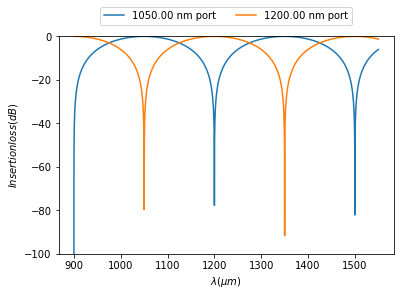

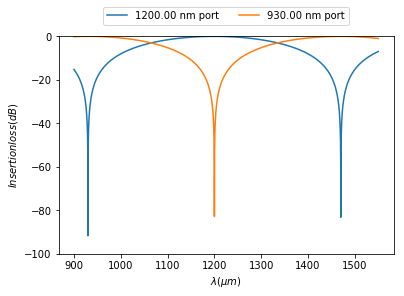

In [13]:
WDM1 = WDM(1050, 1200)
WDM2 = WDM(1200, 930)
WDM1.plot_dB(lv)
WDM2.plot_dB(lv)

### Entry 20/10/2016
I have allot of data including pdf and movies of the simulating CW through the OPO
# wrong

In [ ]:
import io
import base64
from IPython.display import HTML
from scipy.constants import c,pi
import numpy as np
import matplotlib.pyplot as plt
def video(fname):
    video = io.open(fname, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii')))

[All the oscilator](graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space0.pdf)

In [ ]:
video('graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space0.mp4')

[Before_PCF](graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space1.pdf)

In [ ]:
video('graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space1.mp4')

[After_PCF](graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space2.pdf)

In [ ]:
video('graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space2.mp4')

[After_WDM2](graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space3.pdf)

In [ ]:
video('graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space3.mp4')

[After_WDM1_before_pump_added](graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space4.pdf)

In [ ]:
video('graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space4.mp4')

[Exiting wave](graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space5.pdf)

In [ ]:
video('graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space5.mp4')

### Peters Comments
* The delta lines do not seem logical. You need sidebands the same way of MI. Run the simmulation for no WDM's. and see what happens
* You cannot go bellow the quantum noise. When the firt input happens you have noise comming in from the WDM1 on the other power this will lead to the noise floor being the noise floor.



### Entry 27/1/2016
Have taken a break from this so that to write a presentation for the CDT. Will have to take another break because of the poster the CDT is asking me to do.

The specific fibre that we have been looking in to (zlobina) has been measured by them and shown in a paper in 2012 (Ekaterina A. Zlobina, Sergey I. Kablukov, and Sergey A. Babin, "Phase matching for parametric generation in polarization maintaining photonic crystal fiber pumped by tunable Yb-doped fiber laser," J. Opt. Soc. Am. B 29, 1959-1967 (2012) ).
Within that she explains that in that fibre $\beta_2 = 0$ THIS EXPLAINS MY CONFUSION!

In the appendix she is kind enough to do the calculations for the phase missmatch up to $\beta_5$. Along with my inclusion for $\beta_2$ which she dissregards we have:

$$
\Delta \beta = \beta(\omega_p +\Omega) + \beta(\omega_p -\Omega) - 2\beta(\omega)
$$

And a central freequency $\omega_0$ we have $\omega = \omega_p - \omega_0$

Within the expansion:

$\beta_0, beta_1$ drops out:

* $\beta_2 \Rightarrow \beta_2 \Omega^2$
* $\beta_3 \Rightarrow \beta_3 \omega \Omega^2$
* $\beta_4 \Rightarrow \frac{\beta_4}{12} \Omega^2\left(\omega^2  + \Omega^2 \right)$
* $\beta_5 \Rightarrow \frac{\beta_5}{12} \Omega^2 \omega\left(2\omega^3  + \Omega^2 \right)$



So 
$$
\Delta \beta (\Omega) = \Omega \left[\left(\frac{\beta_4}{12} + \omega \frac{\beta_5}{12} \right) \Omega^{3} + \left(\beta_2+ \omega \beta_3 + \omega^{2}\frac{\beta_4}{2} + \omega^{3} \frac{\beta_5}{6}\right) \Omega \right]
$$


From the agrawal (no pump depletion), which we can assume in these cases since the fibre is not that long. Pase matching occurs when:


$$
\Delta \beta ^{'} = \Delta \beta + 2 \gamma P_{0} = 0 
$$

Then with 

$$
a = \frac{\beta_4}{12} + \omega \frac{\beta_5}{12}
$$

$$
b = \beta_2+ \omega \beta_3 + \omega^{2}\frac{\beta_4}{2} + \omega^{3} \frac{\beta_5}{6}
$$

and 

$$
c = 2 \gamma P_{0}
$$

Phase matching will occur at:

$$
\Omega = \sqrt{\frac{-b \pm \sqrt{b^2 - 4 a c}}{2a}}
$$

, with omega real and possitive.

HOWEVER remember difference in $\omega$ does not mean difference in $\lambda$.


The parametric $\lambda's$ are found by:

$$\lambda_s = \lambda_p + \frac{\Omega \lambda^2_p}{(2\pi c - \Omega \lambda_p)}$$

$$\lambda_i = \lambda_p + \frac{\Omega \lambda^2_p}{(-2\pi c - \Omega \lambda_p)}$$

In [89]:
%matplotlib inline

930.043370861 1200.61679784


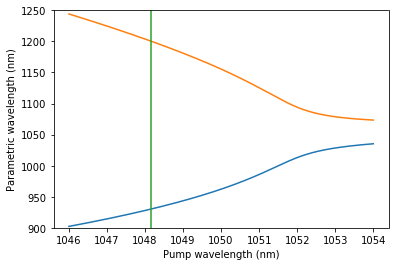

In [109]:
import sys
from scipy.constants import c,pi
import numpy as np
from math import factorial
import matplotlib.pyplot as plt
def betas_transf(betas, lamdap,lamdac):
    omegap = 2* pi * c / lamdap
    omegac = 2 * pi * c /lamdac
    betap = np.zeros(np.shape(betas))
    for i,b in enumerate(betas):
        if i == 1000:
            betap[i] = betas[i]
        else:
            temp = 0
            fact_count = 0
            for j in range(i, len(betas)):
                #print(i, betas[j], fact_count)
                temp += factorial(fact_count)*betas[j] * (omegap - omegac)**fact_count
                fact_count +=1
            betap[i] = temp
    return betap


def domega(omegap,omega0,beta,gama, P0):
    omega = omegap - omega0
    a = beta[4]/12 #$+ omega * beta[5]/12
    b = beta[2]#+ omega*beta[3] +omega**2 * beta[4]/2 + omega**3 * beta[5]/6
    cc = 2 * gama * P0
    
    det = b**2 - 4 * a * cc
    if det >= 0:
        Omega = (-b + det**0.5)/(2*a)
        
        if Omega <0:
            Omega = (-b - det**0.5)/(2*a)
        if Omega <0:
            print("No real solution!")
            sys.exit("No real solution!")
        else:
            #print(Omega)
            return Omega**0.5
                

    else:
        print(' No real sollution in the det', det)
        sys.exit(' No real sollution in the det', det)

    return 1

def dlamda_sig(Omega,lamdap):
    return Omega * lamdap**2 / (2* pi* c - Omega * lamdap)*1e9

def dlamda_idl(Omega,lamdap):
    return Omega * lamdap**2 / (-2* pi* c - Omega * lamdap)*1e9

N = 2**15
beta0 = 0
beta1 = 0
beta2 = 0
beta3 = 6.756e-2 *(1e-12)**3*1e-3
beta4 = -1.002e-4 * (1e-12)**4*1e-3
beta5 = 3.671*1e-7*(1e-12)**5*1e-3
betas_or = [beta0,beta1,beta2,beta3,beta4,beta5]
lamda_fast, lamda_slow = 1052.95e-9, 1051.85e-9
lamda0 =  lamda_slow
lamdap_const = 1.0488816316376193e-06
lamdap_const = 1051.0e-9
lamdaP_vec = (1047.5e-9, 1047.9e-9, 1048.3e-9, 1048.6e-9,1049.0e-9, 1049.5e-9, 1049.8e-9, 1050.2e-9, 1050.6e-9, 1051.0e-9, 1051.4e-9)
lamdaP_vec = (1048.15e-9,)
for lamdap_const in lamdaP_vec:
    lamdaps = np.linspace(1046e-9,1054e-9,N)
    lamdaps = np.ndarray.tolist(lamdaps)
    lami = []
    lams = []
    for lamdap in lamdaps:
        betas = betas_transf(betas_or, lamdap,lamda0)
        Omega  = domega(2*pi *c /lamdap,2*pi *c /lamda0,betas,10*1e-3,13.5)
        dlamda_s= dlamda_sig(Omega,lamdap)
        dlamda_i =dlamda_idl(Omega,lamdap)
        #print(lamdap*1e9 + dlamda_i)
        lami.append(lamdap*1e9 + dlamda_i)
        lams.append(lamdap*1e9 + dlamda_s)
    lamdaps = [i*1e9 for i in lamdaps]

    loc = np.argsort(np.abs(np.asanyarray(lamdaps) - lamdap_const*1e9))[0] # location of the lamda0
    
    plt.plot(lamdaps,lami, label='idler')
    plt.plot(lamdaps,lams, label='signal')
    #plt.plot(A[:,0],A[:,1], label='mmgnlse')
    #plt.plot((lamda_fast*1e9,lamda_fast*1e9),(900,1250), label='fast zer disp')
    #plt.plot((lamda_slow*1e9,lamda_slow*1e9),(900,1250), label='slow zer disp')
    plt.plot((lamdap_const*1e9,lamdap_const*1e9),(900,1250), label='asked_for_wavelength')

    plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
    plt.ylabel('Parametric wavelength (nm)')
    plt.ylim([900,1250])
    #plt.legend(loc=1)
    plt.xlabel('Pump wavelength (nm)')
    #plt.show()
    #plt.close('all')
    #plt.show()
    #print("The asked for pump wavelength ", lamdap_const*1e9,"nm results in hits of:",lami[loc] ,"nm idler and:",lams[loc],"nm signal.",)
    print(lami[loc], lams[loc])

In [99]:
def find_lami(lamdap, lamda0, betas, gama, P0,lamdai_asked,betas_or):
    betas = betas_transf(betas_or, lamdap,lamda0)
    Omega  = domega(2 * pi * c / lamdap, 2 * pi *c / lamda0, betas, gama, P0)
    #dlamda_s= dlamda_sig(Omega,lamdap)
    dlamda_i =dlamda_idl(Omega,lamdap)
    print(lamdap,lamdap*1e9 + dlamda_i - lamdai_asked)
    return lamdap*1e9 + dlamda_i - lamdai_asked

In [100]:
from scipy.optimize import fsolve

In [7]:
a = fsolve(find_lami,lamdap_const, args = (lamda0, betas, 10e-3, 5,942,betas_or),xtol=1.49012e-12,factor =0.1 )

[  1.05140000e-06] [ 60.14446754]
[  1.05140000e-06] [ 60.14446754]
[  1.05140000e-06] [ 60.14446754]
[  1.05140002e-06] [ 60.14502782]
[  1.04971819e-06] [ 15.4276321]
[  1.04913796e-06] [ 4.47560271]
[  1.04890084e-06] [ 0.36783955]
[  1.04887961e-06] [ 0.00895543]
[  1.04887908e-06] [  1.80342056e-05]
[  1.04887908e-06] [  8.83346729e-10]
[  1.04887908e-06] [  1.59161573e-12]


In [21]:
a[0]

1.0488816316376193e-06

### Entry 9/11/2016
    The code now finds the sidebands as shown above when run for only one dirrection. The accuracy of the integration needs to be very high to get themn unfortunately yet some speedup has been achieved by mklfft.

### Entry 14/11/2016
    Excelents. 10 tests are passing whcih all have to do with the pulse propagation within the fibre. However the WDM systems seem to have a problem. 
    
The insetion loss is found by [Reference to the lecture I found]:
    $$ IL = 10 log \left(\frac{P_{in}}{P_{out}}\right)$$ 
    
But in my definition it is the output over the input hence:
        $$ IL = 10 log \left(\frac{P_{out}}{P_{in}}\right)$$ 


### Entry 15/11/2016
Peter has said that technically the way I have modeled the WDM system is wrong. This is because the insertion loss above is the one for powers when U in the code is square root of power in arbitary units.

Taking in to account the figure:

<img src="graphs_for_logs/single_mode_single_dirrection/WDM_model.png">.





The matrix that can represent the system is shown:

$$\begin{bmatrix}
    U^{1}_{out}         \\
    U^{2}_{out}      
\end{bmatrix} =
\begin{bmatrix}
    cos(f(\lambda))       & sin(f(\lambda)) \\
    -sin(f(\lambda))       &  cos(f(\lambda)) 
\end{bmatrix}\begin{bmatrix}
    U^{1}_{in} \\
    U^{2}_{in}      
\end{bmatrix}
$$

The extra input should be noise. In both cases the WDM needs to have 2 outputs and two inputs.

### Entry From a.u. to dBm/nm

$$
E(j) = \int_{0}^{T} \left|u(t)\right|^{2} dt = \int \left|U(\omega)\right|^{2} d\omega = \int \left|U(\lambda)\right|^{2} d\lambda 
$$

So 
$$
P = \frac{E(\lambda)}{T} = \int \frac{\left|U(\lambda)\right|^2}{T} d \lambda 
$$

### ENtry 22/11/2016
Working on three pillars of the code. Needs to work by Friday 
* Introduce freequency based attenuation on the sides to eliminate the periodic FWM 
* Write a test for a.u. to dBm/nm and then use it in the equation
* add attenuation on the WDM systems themselves. 

From which:
* done and tested
* done and tested
* Not needed

# After that I should consider what to run this model on that would reduce to a 2 page abstract for CLEO. 


# Entry 25/11/2016 Meeting

Dave Richardson would like somethng in the 2000nm conversion. This can be done. 


Continue working on the program. Tests it etc And think of Novel things for CLEO USA.

### Entry 30/11/2015
I have written/tested and virigously changed the code to an acceptable result. I use hdf5 to export my data and export ALLOT of it. Next immediate thing is to looka t why the idler has a kink when the signal does not (the soliton hypothesis).



# The soliton hypothesis
In order to get a soliton we will need a soliton umber being an intiger. With the soliton number being:


$$ N = \sqrt{\frac{\gamma P T^2}{\left|\beta_{2}\right|}} = \sqrt{\frac{L_{D}}{L_{NL}}} $$

Out of this we know gamma and $\beta_2 = \beta_3 \left( \omega_p - \omega_0\right) +\frac{\beta_4}{2} \left(\omega_p - \omega_0\right)^2$.

In [ ]:
from scipy.constants import c,pi
def beta2_func(lamdap):
    omegap = 2*pi*c/lamdap
    omega0 = 2*pi*c/1051.85e-9
    beta3 = 6.755e-2 *(1e-12)**3*1e-3
    beta4 = -1.001e-4 * (1e-12)**4*1e-3
    beta2 = (omegap - omega0)*beta3 + 0.5*beta4 * (omegap + omega0)**2
    return beta2

In [ ]:
beta2 = beta2_func(1047.5e-9)
gamma = 10*1e-3
T = 2.4e-12
P = 12
N = (gamma*P*T**2/(-1*beta2))**0.5
print(N)

# Entry 2/12/2016
### So it turns out there is no Soliton. 
Proof in:
[No soliton!](graphs_for_logs/single_mode_single_dirrection/Post+processing+specific.pdf)

# Entry 3/12/2016
So since there is no real result from the soliton story we look in to others. Peter has said top do:
1. Play with pump wavelength (kind of done in the paper itself)
2. Play with pump power (how much power is to much power?
3. Integrate idler area for the **conversion efficiency**
4. Seed
    1. change power
    2. change wavelength
    3. see the amount of noise that is at the output
5. Pulses

Answers to these ideas:
1. done that. not much to give
2. Pump power. There seems to be a threshold at which the maximum gain is heard. [reference OPO theory book] **useless to look at powers** this shows in my result
3. Integrate really? Nee dto think about this
4. 



### Entry 8/11/2016 On conversion efficiency

In order to calculate the conversion efficiency one needs to find the power of the idler. 

But since the idler will move according to things like power, wavelength or if you seed we require a computational definition that wilkl be good for all.

**Idler definition**: 

At the point of the FOPO reaching a steady state the wavelength of the idler is defined as the wavelgength that has the highest power at shorter wavelengths to thaat of the pump plus an error number. That error number is so that the amplified noise around the pump wavelength can be dissregarded. 

Note 1: This can also apply to the signal but in longer wavelengths.

Note 2: consider thhat you seed the FOPO. But the idler is not what you would expect from the seed. The idler is still the one that has the highest power regadless. 


** conversion efficiency**:
By conversion efficiiency I call the conversion efficiency of the FOPO ie what set in and what exists the FOPO. Not to be confused with the conversion efficiency of the fibre parametric amplifier. 


To get the conversion efficiency one needs to find what he will consider as the idler power. 
My default definition to this is:

$$ CE = \frac{P_{out}}{P_{in}}$$ 

In the case CW $$P_{in} = P_{p} + P_{s}$$ is the pump at the input. 

The idler pump however is found by:

$$ P_{out} = \frac{\int^{a}_{b} \left|U(f)\right|^2 df}{T}$$

where $a$ and $b$ are the limits. I set the limits as default to be : $a,b =  f_{i} +,- 5 $ $ Thz$

# Entry meeting 9/12/2016
You could also look in to how the steady state is achived. 

ie a graph of how the power reaches the steady state. 

# Entry beofre christmas on splice model etc

The original splice losses that I had was wrong. My problem was that I was considering the powers and not the electric field. 


Firstly a little bit about the beam splitter model. 
We assume a **lossless** beam splitter with two input electric fields ($E_{in1}$,$E_{in2}$)  and two outputs ($E_{out1}$,$E_{out2}$). 

The output electric field is subject to the input from the matrix equation:

$$\begin{bmatrix}
    E^{1}_{out}         \\
    E^{2}_{out}      
\end{bmatrix} =
\begin{bmatrix}
    c_1       & c_2 \\
    -c_2       &  c_1 
\end{bmatrix}\begin{bmatrix}
    E^{1}_{out} \\
    E^{2}_{out}      
\end{bmatrix}
$$.


The first coefficient $c_1$ is found by assuming that no input is comming in to input port 1 and the second comes from equationg that the total energy needs to be conserved:
 $$
  \left|E^{1}_{out} \right|^2 + \left|E^{2}_{out} \right|^2 = \left|E^{1}_{in} \right|^2 + \left|E^{2}_{in} \right|^2
 $$
.

Now for the splice loss itself. It is simmilar to the WDM model but with the prime exception that it is not freequency dependent. 

If $L$ is the splice loss in $dB$ then $$L = 10 log \left(\frac{P_{out}}{P_{in}}\right)$$ with $L<0dB$.

Hence the power at the output 1 if there is no input at port 2 is:

$$\left|E^{1}_{out} \right|^2 = P_{out1} = 10^{0.1L} P_{in1}$$

and hence one can conclude $$c_{1} = 10^{0.1 L}$$
.


$c_{2}$ can then be found by using the conservation of energy above and is found to be:
$c_{2} = \pm \left(1 - 10^{0.1 L} \right)^{0.5}$


**The same principle works on the WDM model**


# Things to do after christmas on the FOPO system 

1. Find proof that the NLSE works on the CW regime
2. Look at the threshold power needed for our fopo and match it to the FOPO in the paper
3. Figure out a concrete way to set a final sollution for the idler. 100 is sometimes to much and others not enough. 
4. Look at the discrepencies between the idler wavelengths that are coming out in the NLSE and what is actually expected by the basic theory. 
5. on the lter I used fsolve bove to inverseley clculte the pump wvelgth needed. I seem to be bit off originly, remember to run it.

# Back after christmas
1. So in agrawal when he introduces the modulation instability for CW he talks from the NLSE. This to me is proof enough that it does work 


# The marhic power threshold
According to Marhic (optical parametric amplifiers, oscilators and related devices) the threshold power of the FOPO is found by: 
$$
P_{th} = \frac{1}{\gamma L} arcosh \left(\frac{1}{\sqrt{T}}\right)
$$

So I use the FOPO parameters quoted and see bellow

 the paper quotes: 3.2720235024 3.56197188739 threshold powers for transmitance of: 0.72 0.68 at wavelengths of 930nm and 940 nm respectively


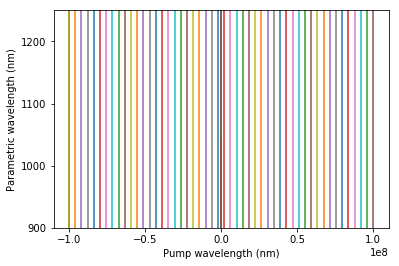

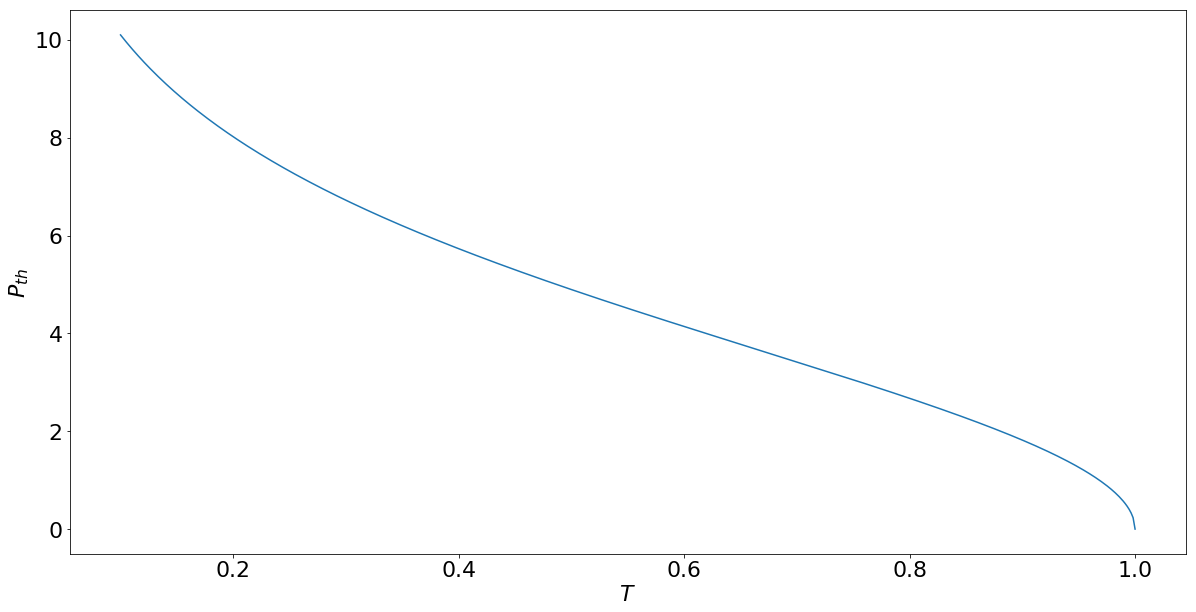

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from math import acosh
import matplotlib
font = {'family' : 'sans-serif',
        'size'   : 22}
matplotlib.rc('font', **font)

acosh = np.vectorize(acosh)
g = 10e-3
#g = 0.00092795
L = 18
T = np.linspace(0.1,1,512)



def P_th(T, g , L):
    a = (g*L)**(-1)
    b = acosh(np.sqrt(T)**(-1))
    return a*b

P = P_th(T,g,L)
print(' the paper quotes:', P_th(0.72,g,L), P_th(0.68,g,L), 'threshold powers for transmitance of:', 0.72, 0.68,'at wavelengths of 930nm and 940 nm respectively')

fig = plt.figure(figsize=(20.0, 10.0))
plt.plot(T,P)
plt.xlabel(r'$T$')
plt.ylabel(r'$P_{th}$')
plt.show()

In [10]:
def find_P_th(T, P_find, g, L):
    return np.abs(P_th(T, g,L) - P_find)

#### The paper quotes theoretical threshold powers at:

In [11]:
a = fsolve(find_P_th, 0.72, args = (3.3, g,L),xtol = 1e-13)
print('Transmittance of',a[0])

Transmittance of 0.716160016284


In [12]:
a = fsolve(find_P_th, 0.68, args = (3.6, g,L),xtol = 1e-12)
print('Transmittance of',a[0])

Transmittance of 0.674732770867


##### While mine finds:


In [13]:
a = fsolve(find_P_th, 0.68, args = (5.5, g,L),xtol = 1e-12)
print('Transmittance of',a[0])

Transmittance of 0.426402309857


This is very different!!!

**Hypothesis**:

From the above we can see that the approximate 5.5W that we see as the threshold power in the model can be attributed to high losses in the system. I need to make sure I have the same transmition as the paper quotes that... changes with wavelength. 

# The problem of loss
It seems that due to the many splice losses I am expiriencing a larger threshold power. 
If the dB in loss is found by:

$$
L = 10 log \left( \frac{P_{out}}{P_{in}} \right)
$$

Then the Transmitence can be found by:

$$
T  =  \frac{P_{out}}{P_{in}} = 10^{\frac{L}{10}}
$$
under I will have some python code with examples.


In [9]:
10**(-0.5/10)

0.8912509381337456

In [23]:
def Trans(L):
    return 10 **(L / 10)

In [24]:
L  = np.linspace(-50, -0.001)

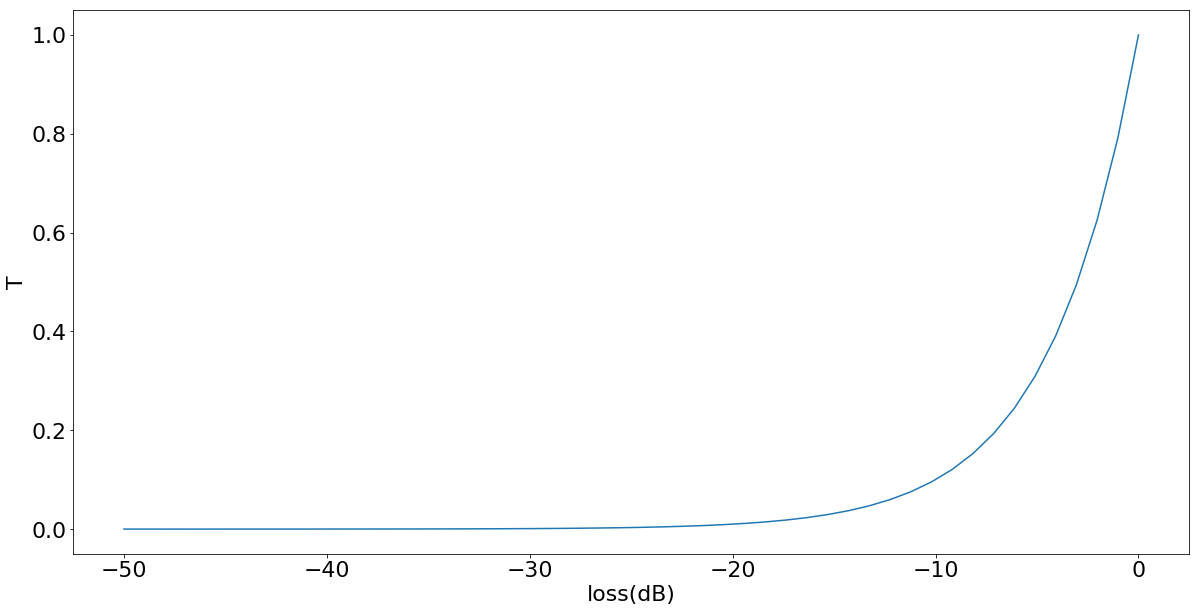

In [25]:
fig = plt.figure(figsize=(20.0, 10.0))
plt.plot(L,Trans(L))
plt.xlabel('loss(dB)')
plt.ylabel('T')
plt.show()

#### So I am going to use the losses of both the WDM's and the splice losses

In [82]:
%matplotlib inline

In [9]:
from functions import *
# Define splice losses
l1, l2 = 0.3895,0.225630004434
#l1, l2 = 10,0
lv = np.linspace(900, 1250,1024)
fv = c/lv
WDM1 = WDM(1050, 1200,fv,c)
WDM2 = WDM(930, 1200, fv,c)
WDM3 = WDM(930, 1050,fv,c)
WDM4 = WDM(930, 1200,fv,c)

def db(x):
    return 10*np.log10(x)

def wdm_losses(l):
    return db(WDM1.il_port2(l)) + db(WDM2.il_port2(l))# + db(WDM3.il_port1(l)) + db(WDM3.il_port1(l))
    

def total_loss(l, l1,l2):
    return   + wdm_losses(l) - 0.021-2*l1 + -3*l2

def totalT(l,l1, l2):
    return 10**(total_loss(l,l1,l2)/10)

In [10]:
def plot_trans(lv):
    fig = plt.figure(figsize=(20.0, 10.0))
    plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
    plt.plot(lv, totalT(lv,l1, l2))
    plt.xlabel(r'$\lambda(nm)$')
    plt.ylabel(r'$T$')

    plt.show()

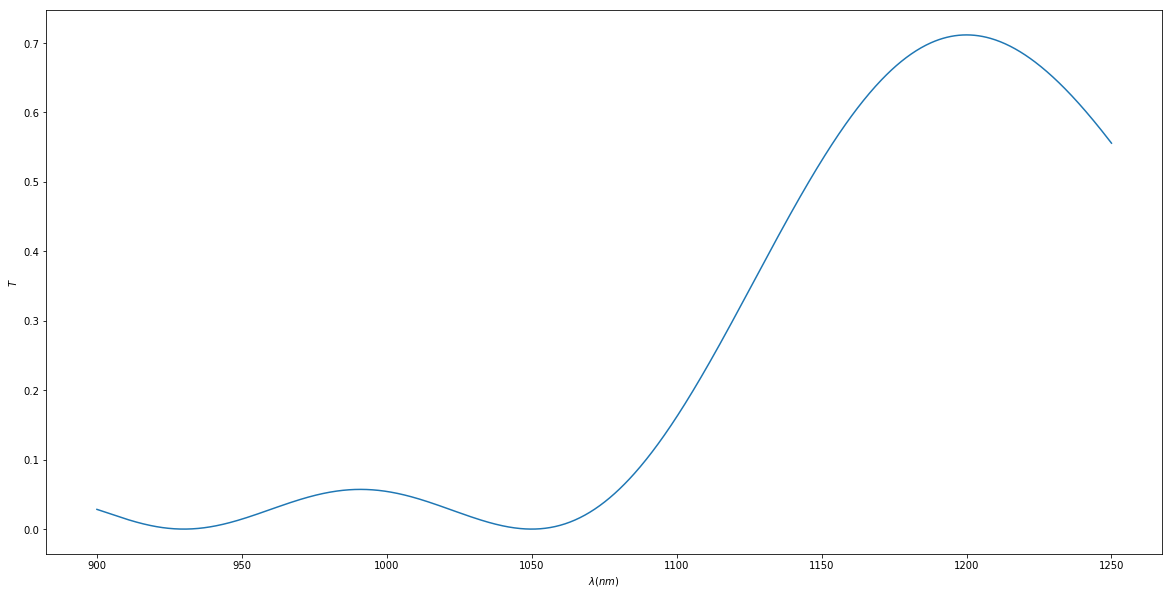

In [11]:
plot_trans(lv)

In [13]:
np.max(totalT(lv,l1, l2))

0.71172281939227855

## But what about the trnsmitence of the ports A and B? what do they look like:
#### For portA:

In [34]:
def wdm_losses(l):
    return  + db(WDM1.il_port2(l))+ db(WDM2.il_port2(l))+ db(WDM3.il_port2(l))+ db(WDM4.il_port2(l))

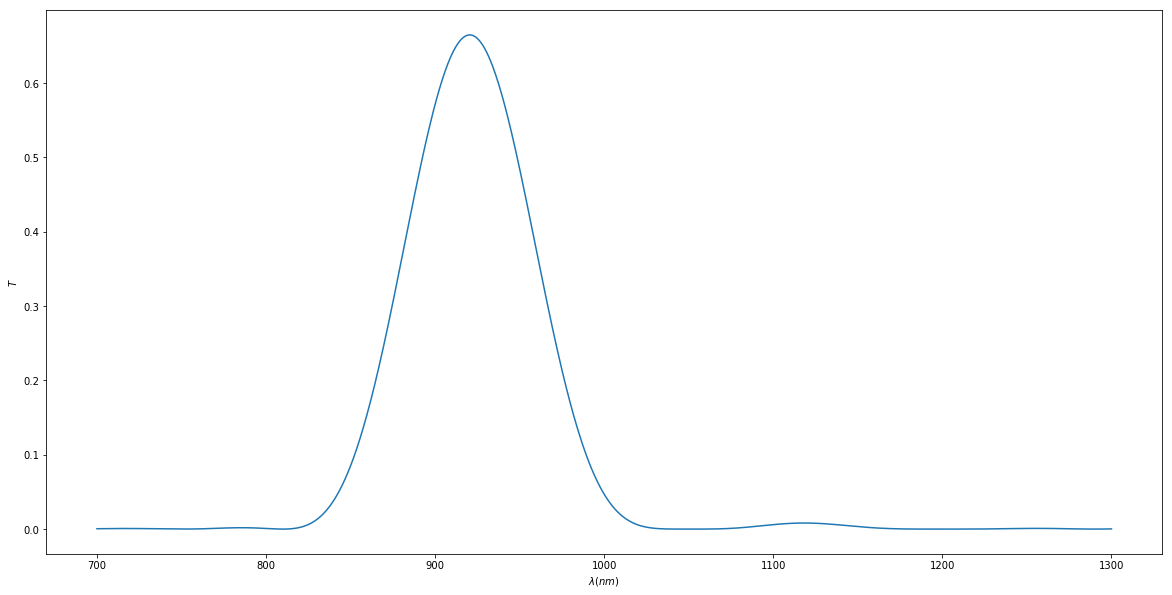

In [35]:
plot_trans(lv)

# And portB:
    

In [40]:
def wdm_losses(l):
    return  + db(WDM1.il_port2(l))+ db(WDM2.il_port2(l))+ db(WDM3.il_port1(l))

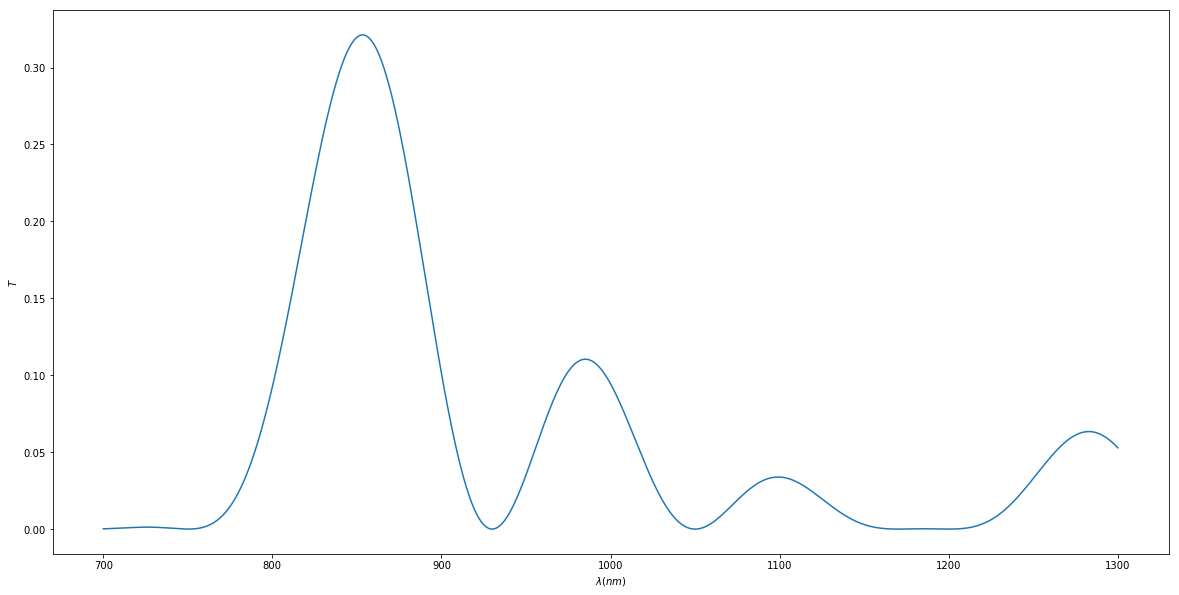

In [41]:
plot_trans(lv)

##### Clearly my transmittance is  low to get those good threshold powers. 
But the paper quotes: 3.2720235024 W 3.56197188739 W threshold powers for transmitance of: 0.72 0.68 at wavelengths of 930nm and 940 nm respectively. So all we need to do is solve/minimize totalT(l,l1, l2) and that would give us the splice losses of the system.
i.e.:

$$
totalT(930,l1, l2) = 0.72
$$

and

$$
totalT(940,l1, l2) = 0.68
$$


In [46]:
def solve_T(l_v):
    l1,l2 = l_v
    return (totalT(930,l1, l2) - 0.716160016284, totalT(940,l1, l2) - 0.674732770867)
l1,l2 = fsolve(solve_T, (0.157012903514,0.1),xtol = 1e-6)
print(l1,l2)    

In [47]:
l1,l2 = fsolve(solve_T, (0.157012903514,0.1),xtol = 1e-6)
print(l1,l2)

-271.126704118 77.5903176693


/home/john/miniconda3/lib/python3.5/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [48]:
l1 = np.linspace(0, 0.2)
l2 = np.linspace(0,0.2)

In [22]:
L1,L2 = np.meshgrid(l1,l2)

In [23]:
z = solve_T((L1,L2))

In [24]:
np.min(z)

-0.14633152826191631

In [25]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np

In [26]:
%matplotlib inline

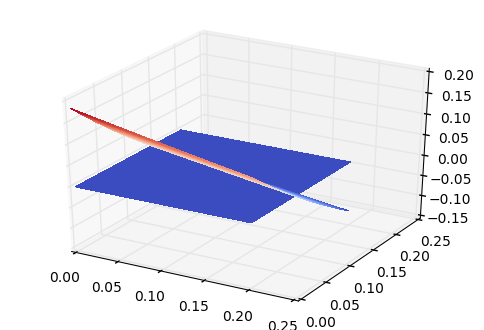

In [27]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(L1, L2, z[0], rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.plot_surface(L1, L2, np.zeros_like(z[0]), rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

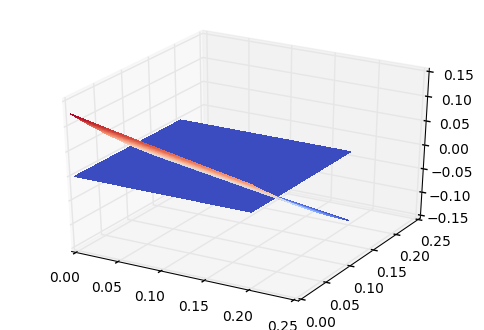

In [28]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(L1, L2, z[1], rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.plot_surface(L1, L2, np.zeros_like(z[0]), rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

# Metting 6/1/2017

He is ok with what I am doing validate the model and then produce papers.


# input on 6/1/2017
since we have established that the total loss with respect to wavelength is found by:
$$
L_{t} = -2l_{1} - 7l_{2} + WDM^{(1)}_{p2}\left(\lambda \right) + WDM^{(2)}_{p2}\left(\lambda \right) + WDM^{(3)}_{p2}\left(\lambda \right) + WDM^{(4)}_{p2}\left(\lambda \right) = -2l_{1} - 7l_{2} + \sum_{i=1}^{4} \left(WDM^{(i)}_{p2}\left(\lambda \right)\right)
$$

, with $l1, l2 >0$ and the transmitence is found by:

$$
T\left(\lambda \right)  = 10 ^{\frac{L_{t}\left(\lambda \right)}{10}}
$$

Then the splice losses can be found by solving:

$$
2l_{1} + 7l_{2} = \sum_{i=1}^{4} \left(WDM^{(i)}_{p2}\left(\lambda \right)\right) - 10\log\left(T\left(\lambda \right)\right)
$$

Now as stated above the paper quotes two transmitences at two seperate wavelengths. This allows us to calculate the splice losses by solving the coupled linear equations of:


$$
2l_{1} + 7l_{2} = \sum_{i=1}^{4} \left(WDM^{(i)}_{p2}\left(930 \right)\right) - 10\log\left(0.72\right)
$$

$$
2l_{1} + 7l_{2} = \sum_{i=1}^{4} \left(WDM^{(i)}_{p2}\left(940 \right)\right) - 10\log\left(0.68\right)
$$
sollution down here in python using numpy linalg solve.

In [29]:
def rhs(lamda, T):
    return wdm_losses(lamda) - 10 * np.log10(T)

In [30]:
a = np.array([[2,7],[2,7]])
b = np.array([rhs(930, 0.72),rhs(940, 0.68)])

In [31]:
x = np.linalg.solve(a,b)

LinAlgError: Singular matrix

# OK SO THAT WAS WRONG!
It is because Zlobina quotes the tansmitance within the god damn cavity! FFS!



In [189]:
WDM1 = WDM(1200, 1050,lv)
WDM2 = WDM(930, 1200, lv)

In [222]:
def l2(lamda, T, l1):
    num = WDM1.il_port1(lamda) + WDM2.il_port2(lamda) - 10 * np.log10(T) - 2*l1
    return num/2

In [223]:
print('the splice loss of the small loss ones is:', l2(1205, 0.72, 0.4895), 'dB')

the splice loss of the small loss ones is: 0.225630004434 dB


# To Do

make sure that you understand the ports correctly and that the loss of the other ones are correct

# Entry 

It seems that the Raman is to blame for the losses of the power and by extension the power threshold. This is probably a scripting error or could even be an error in assuming that the fibre is silica(since it is clearly a PCF). 

I have changed tests to use np.testing.allclose which is more brutal in the errors (rel = 1e-7). At first the soliton tests failed which again was because of the raman.

Increasing the grid seems to go nothing. Nor does making it take more steps.
The Silica gain used is calculated loaded below:

In [85]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d, InterpolatedUnivariateSpline

In [86]:
D = loadmat('loading_data/silicaRaman.mat')

In [87]:
D.keys()

dict_keys(['t1', 'ht', '__header__', '__version__', '__globals__'])

In [88]:
t1 = D['t1']
ht = D['ht']

In [89]:
from fft_module import *
fft, ifft, fft_method = pick(5, 1, 100)
from scipy.fftpack import fftshift

In [90]:
fft?

In [91]:
t = np.linspace(-15,15,1024)
dt = t[1] - t[0]
htmeas_f = InterpolatedUnivariateSpline(t1*1e-3, ht)
htmeas = htmeas_f(t)
htmeas *= (t > 0)*(t < 1)    # only measured between +/- 1 ps)
htmeas /= (dt*np.sum(htmeas))    # normalised

In [100]:
dt

0.029325513196480912

In [95]:
hf = fft(htmeas)

In [99]:
hf

array([ 34.10000000+0.j        , -34.09738735+0.1164675j ,
        34.08957357-0.23252499j, ..., -34.07663065-0.34776932j,
        34.08957357+0.23252499j, -34.09738735-0.1164675j ])

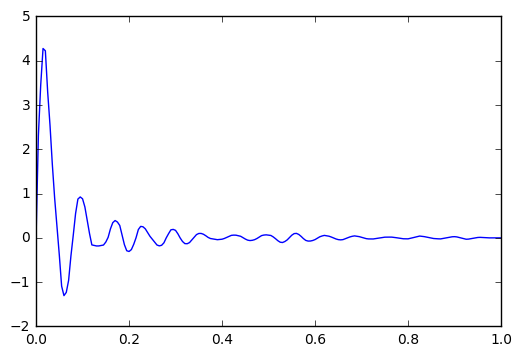

In [116]:
plt.plot(t1*1e-3,ht)
plt.show()


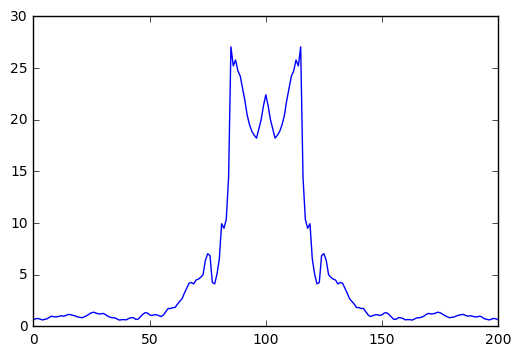

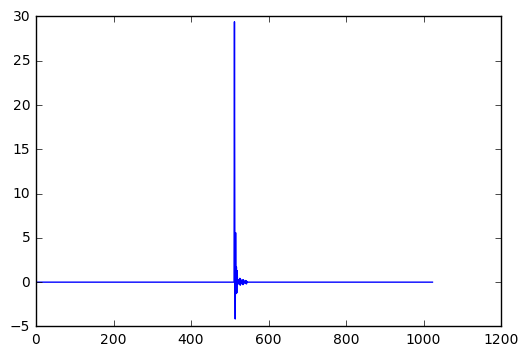

In [83]:
plt.plot(np.abs(fftshift(fft(ht))))
plt.show()
plt.plot(htmeas)
plt.show()

/home/john/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


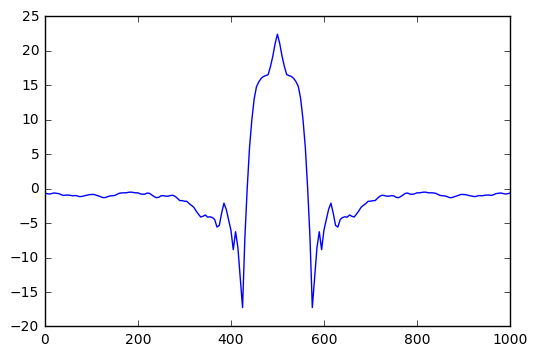

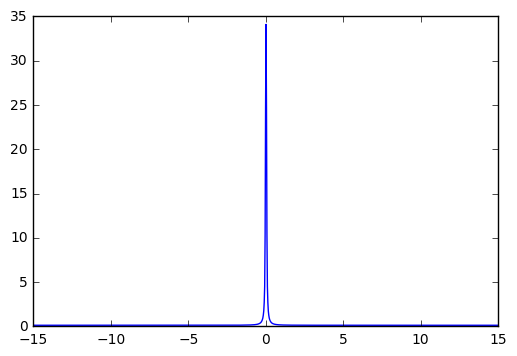

In [81]:
plt.plot(t1,fftshift(fft(ht)))
plt.show()
plt.plot(t,fftshift(fft(htmeas)))
plt.show()

# Entry 16/1/2017
Some thing you need to consider is if it actually reaching the steady state. Yeah sure the high power ones are but the low powers would take allot longer to reach the steady state.

What will be a steady state????

Another thing you need to think about it the fluctuations of the power. Would the average reach the steady state and not the power due to lets say noise or simple oscilation of attenuation and parametric amlification? Maybe consider the power over a arbitary number of iterations and comapre that one to zlobina?


# Entry 18/1/2017
The system is messy, lossy, unstable, one may even say chaotic.As in Zhang et al. we see weird instability in certain situations. One cannot really talk about a steady state because the systems just oscilates. The other paper, having done pulses has established that the feedback ratio of the signal is to blame and that lower feedback ratio results in a stable system. I think there is allot more that beats the eye in this system. What if out cavity was smaller? what if I remove one WDM? would this result in something better? Worse? What are the paremeters for stability.

Another question one needs to ask is the validation. While the model explores and shows very similar results to zlobina etal numerically it differs. I can now confirm that one, if not the only, reason for this is the instability of the system which is *NOT* picked up by the OSA since I see very small timeframes compared to what it can see. Could the average of this be my validation? What if... I reached the oscilating part and averaged it. Would this be the numbers that zlobina is quoting? This may be the case. 



### Graphs of number of rounds. 
I run a 10.5W input pump over a range of 2000 iterations. 


pump wavelength $\lambda = 1.0488816316376193\mu m$, power  $P_{in} = 10.5 W$

Over 5 iterations was:


<img src="graphs_for_logs/single_mode_single_dirrection/rounds_output/5.png">

Over 400:

<img src="graphs_for_logs/single_mode_single_dirrection/rounds_output/400.png">

Over 400:

<img src="graphs_for_logs/single_mode_single_dirrection/rounds_output/2000.png">

Different powers for the same wavelength as earlier. 

$$P_{in} = 7 W$$

<img src="graphs_for_logs/single_mode_single_dirrection/rounds_output/powers/0.png">





$$P_{in} = 8 W$$

<img src="graphs_for_logs/single_mode_single_dirrection/rounds_output/powers/1.png">




$$P_{in} = 9 W$$

<img src="graphs_for_logs/single_mode_single_dirrection/rounds_output/powers/2.png">




$$P_{in} = 10 W$$

<img src="graphs_for_logs/single_mode_single_dirrection/rounds_output/powers/3.png">




$$P_{in} = 11 W$$

<img src="graphs_for_logs/single_mode_single_dirrection/rounds_output/powers/4.png">

## comment from the meeting:

* He likes it for some reason.

# URGENT
Discrepency between resulting idler FOPO wavelengths and expected from the simple theory


### No it is ok.

The probelm is on what I call maximum. Because of the noise the errors are rampant. you would have to run this a number of times(monte carlo) to get the exact sidepands. 

# Entry on the splice loss

Now Zlobina et al. confused me because the quoted the transmition with respect to the signal oscilating in the cavity not the idler as it originaly appears to be.

So 
first *I need to find the signal power that is playing in the cavity* and afterwards calculate the inserion losses according to the losses in the cavity only. 

So as above, if we are to believe the non depletion of the pump approximation then we can use idler wavelength quoted to calculate the signal wavelength in both sittuations of 930nm and 940nm. Copying the analysis above gives us:



In [13]:
%matplotlib inline
import sys
from scipy.constants import c,pi
import numpy as np
from math import factorial
import matplotlib.pyplot as plt


In [80]:

def betas_transf(betas, lamdap,lamdac):
    " Does the transofrmation of the betas with respect to pump and the original central wavelength"
    wc = 2*pi * c / lamdap
    w0 = 2*pi * c / lamdac
    betap = np.zeros_like(betas)
    for j in range(len(betas)):
        if j ==0:
            betap[j] = betas[j]
        fac = 0
        for k in range(j, len(betas)):
            betap[j] += factorial(fac)**(-1) * \
                    betas[k] * (w0 - wc)**(fac)
    return betap
def betas_transf(lamda, lamda_c, betas):
    c_norm = c  # Speed of light [m/ps] 
    wc = 2*pi * c_norm / lamda
    w0 = 2*pi * c_norm / lamda_c
    betap = np.zeros_like(betas)
    for i in range(1):
        for j in range(len(betas.T)):
            if j ==0:
                betap[i,j] = betas[i,j]
            fac = 0
            for k in range(j, len(betas.T)):
                #print(j,k, factorial(fac), betas[i, k], (wc - w0)**(fac))
                betap[i, j] += factorial(fac)**(-1) * \
                    betas[i, k] * (wc - w0)**(fac)
                fac += 1
    print(np.shape(betap))
    sys.exit()
    return betap[0]


def domega(omegap,omega0,beta,gama, P0):
    omega = omegap - omega0
    a = beta[4]/12 #$+ omega * beta[5]/12
    b = beta[2]#+ omega*beta[3] +omega**2 * beta[4]/2 + omega**3 * beta[5]/6
    c = 2 * gama * P0
    
    det = b**2 - 4 * a * c
    if det >= 0:
        Omega = (-b + det**0.5)/(2*a)
        
        if Omega <0:
            Omega = (-b - det**0.5)/(2*a)
        if Omega <0:
            print("No real solution!")
            sys.exit("No real solution!")
        else:
            #print(Omega)
            return Omega**0.5
                

    else:
        print(' No real sollution in the det', det)
        sys.exit(' No real sollution in the det', det)

    return 1

def dlamda_sig(Omega,lamdap):
    return Omega * lamdap**2 / (2* pi* c - Omega * lamdap)*1e9

def dlamda_idl(Omega,lamdap):
    return Omega * lamdap**2 / (-2* pi* c - Omega * lamdap)*1e9

In [81]:

def plot(sols):
    N = 2**15
    lamdap_const = sols
    lamdaps = np.linspace(1046e-9,1054e-9,N)
    lamdaps = np.ndarray.tolist(lamdaps)
    lami = []
    lams = []
    for lamdap in lamdaps:
        betas = betas_transf(betas_or, lamdap,lamda0)
        Omega  = domega(2*pi *c /lamdap,2*pi *c /lamda0,betas,10*1e-3,5)
        dlamda_s = dlamda_sig(Omega,lamdap)
        dlamda_i = dlamda_idl(Omega,lamdap)
        lami.append(lamdap*1e9 + dlamda_i)
        lams.append(lamdap*1e9 + dlamda_s)
    lamdaps = [i*1e9 for i in lamdaps]

    loc = np.argsort(np.abs(np.asanyarray(lamdaps) - lamdap_const*1e9))[0] # location of the lamda0

    plt.plot(lamdaps,lami, label='idler')
    plt.plot(lamdaps,lams, label='signal')
    #plt.plot((lamdap_const*1e9,lamdap_const*1e9),(900,1250), label='asked_for_wavelength')
    plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
    plt.ylabel('Parametric wavelength (nm)')
    plt.ylim([900,1250])
    #plt.legend(loc=1)
    plt.xlabel('Pump wavelength (nm)')
    print("The asked for pump wavelength ", lamdap_const*1e9,"nm results in hits of:",lami[loc] ,"nm idler and:",lams[loc],"nm signal.",)
    plt.show()
    return lamdap_const*1e9, lami[loc], lams[loc]


In [82]:
def find_dlami(lamp,lamisol, lamda0, betas):
    betas = betas_transf(betas_or, lamp,lamda0)
    Omega  = domega(2*pi *c /lamp,2*pi *c /lamda0,betas,10e-3,5)
    dlamda_i = dlamda_idl(Omega,lamp)
    dlamda_s = dlamda_sig(Omega,lamp)
    lami = lamp*1e9 + dlamda_i
    lams = lamp*1e9 + dlamda_s
    return lami - lamisol*1e9

In [83]:
betas = betas_transf(betas_or, lamda0*10,lamda0)

/home/john/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in true_divide


AttributeError: 'float' object has no attribute 'T'

In [87]:
betas

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.35120000e-40,  -2.00400000e-55,   7.34200000e-70]])

In [85]:
beta0 = 0
beta1 = 0
beta2 = 0
beta3 = 6.756e-2 *(1e-12)**3*1e-3
beta4 = -1.002e-4 * (1e-12)**4*1e-3
beta5 = 3.671*1e-7*(1e-12)**5*1e-3
betas_or = np.array([[0, 0, 0, 6.756e-2*(1e-12)**3, -1.002e-4*(1e-12)**4, 3.671e-7*(1e-12)**5]])*1e-3
lamda_fast, lamda_slow = 1052.95e-9, 1051.85e-9
lamda0 =  lamda_slow

In [86]:
from scipy.optimize import fsolve
pump_tot = []
sol = fsolve(find_dlami,1050e-9, args = (930e-9,lamda0, betas_or))[0]
pump_tot.append(sol)
sol = fsolve(find_dlami,1050e-9, args = (940e-9,lamda0, betas_or))[0]
pump_tot.append(sol)
find_dlami(sol,930e-9, lamda0, betas_or)

#c = plot(sol)[2]
#sol_tot += (c,)

/home/john/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in true_divide


AttributeError: 'float' object has no attribute 'T'

In [60]:
sol_tot = ()
ccc = plot(pump_tot[0])[2]
sol_tot += (ccc,)

IndexError: list index out of range

In [61]:
%matplotlib inline
import sys
from scipy.constants import c,pi
import numpy as np
from math import factorial
import matplotlib.pyplot as plt


In [62]:
ccc = plot(pump_tot[1])[2]
sol_tot += (ccc,)

IndexError: list index out of range

So for 5W of non depleted pump power we get 1200.60329505 nm signal for 930.004954994 idler
and 1183.0523282 nm for 942.043932734 nm of idler.

In order to calculate the total loss within the cavity we follow the signal and add up the WDM losses of WDM1,WDM2 along with 2 large splice losses according followed from the PCF splices and 3 of the normal ones. This leads to below:

In [38]:
sol_tot

(1081.3236183101947, 1081.3236183101947)

In [31]:
from functions import *
# Define splice losses
l1, l2 = 0.4895,0.225630004434
#l1, l2 = 10,0
lv = np.linspace(900, 1250, 512)
fv = c/lv
WDM1 = WDM(1050, 1200,fv,c)
WDM2 = WDM(930, 1200, fv,c)
WDM3 = WDM(930, 1050,fv,c)
WDM4 = WDM(930, 1200,fv,c)

def db(x):
    return 10*np.log10(x)

def wdm_losses(l):
    return db(WDM1.il_port2(l)) + db(WDM2.il_port2(l))# + db(WDM3.il_port1(l)) + db(WDM3.il_port1(l))
    

def total_loss(l, l1,l2):
    return  -2*l1 + -2*l2 + wdm_losses(l) - 0.021

def totalT(l,l1, l2):
    return 10**(total_loss(l,l1,l2)/10)

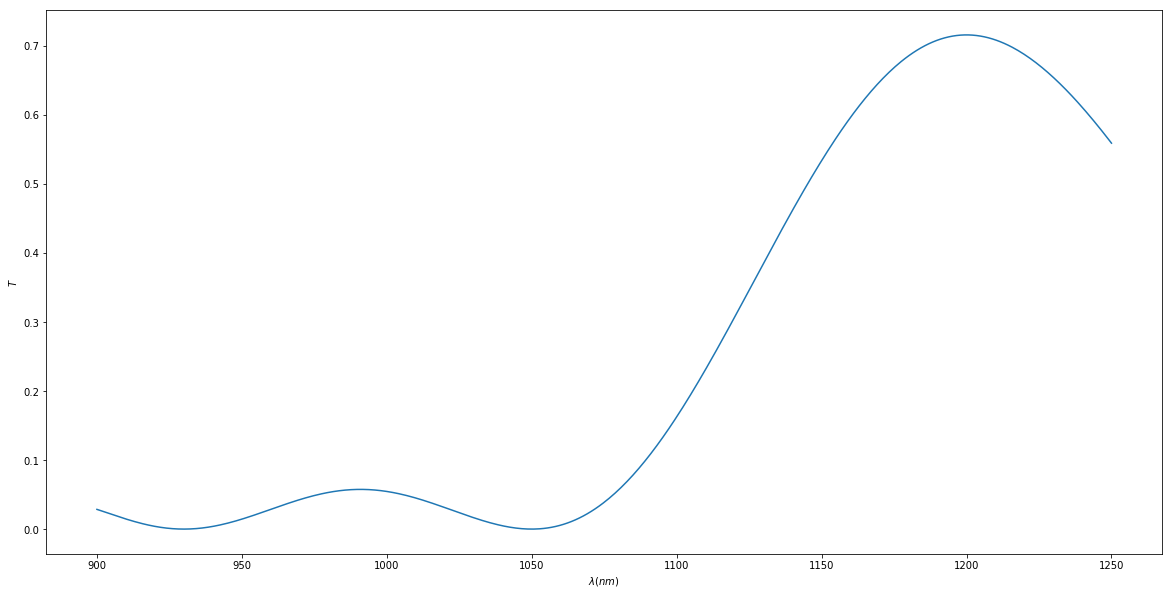

In [32]:

fig = plt.figure(figsize=(20.0, 10.0))
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.plot(lv, totalT(lv,l1, l2))
plt.xlabel(r'$\lambda(nm)$')
plt.ylabel(r'$T$')

plt.show()

In [33]:
print(totalT(sol_tot[0],l1, l2), totalT(sol_tot[1],l1, l2))

0.637190714471 0.637190714471


In [34]:
sol_tot

(1167.6909048975326, 1167.6909048975326)

which is close to what is quoted. So thats correct...I guess.

# Meting 27/1/2017

Graphs:

In [2]:
import numpy as np

In [1]:

np.linspace(1048.8816316376193e-9 - 0.1e-9, 1048.8816316376193e-9 + 0.1e-9,10)*1e9

NameError: name 'np' is not defined

$\lambda_p = 1048.8816316376192$
<img src="graphs_for_logs/large_points_pbef.png">

$\lambda_p = 1048.78163164$

<img src="graphs_for_logs/0.png">

$\lambda_p = 1048.80385386$

<img src="graphs_for_logs/1.png">

$\lambda_p = 1048.82607608$

<img src="graphs_for_logs/2.png">

$\lambda_p =  1048.8482983$

<img src="graphs_for_logs/3.png">

$\lambda_p = 1048.87052053$

<img src="graphs_for_logs/4.png">

$\lambda_p = 1048.89274275$

<img src="graphs_for_logs/5.png">

$\lambda_p = 1048.91496497$

<img src="graphs_for_logs/6.png">

$\lambda_p = 1048.93718719$

<img src="graphs_for_logs/7.png">

$\lambda_p = 1048.95940942$

<img src="graphs_for_logs/8.png">

$\lambda_p = 1048.98163164$

<img src="graphs_for_logs/9.png">

 # Entry regarding dispersion
 
 Ok so I am still not getting much of a change regarding the threshold power. Lets consider the dispersion $D$ of the fibre as shown in: "Phase matching for parametric generation in polarisation maintaining photonic crystal fiber pumped by tunable Yb-doped fiber laser by zlobina:
 

 <img src="graphs_for_logs/dispersion.png">
 
 As stated in persion projects the dispersion $D$ is related to the $\beta_2$ from $D(\lambda) = \frac{-2 \pi c}{\lambda^{2}} \beta_{2}\left(\lambda\right)$ so lets find it from the dispersion operator function and compare.

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, pi
from math import factorial

In [10]:
lamda = np.linspace(100, 1700,2048)*1e-9

In [11]:
def axes(axis):
    if axis == 'fast':
        lamda_c = 1052.95e-9; betas = np.array([[0, 0, 0, 6.753e-2, -1.001e-4, 2.753e-7]])*1e-3
    elif axis == 'slow':
        lamda_c = 1051.85e-9; betas = np.array([[0, 0, 0, 6.756e-2, -1.002e-4, 3.671e-7]])*1e-3
    else:
        lamda_c = 1052.44e-9; betas = np.array([[0, 0, 0, 6.755e-2, -1.001e-4, 2.673e-7]])*1e-3
    return lamda_c, betas

In [12]:
def dispersions(lamda, lamda_c, betas):
    c_norm = c*1e-12  # Speed of light [m/ps] 
    wc = 2*pi * c_norm / lamda
    w0 = 2*pi * c_norm / lamda_c
    betap = np.zeros_like(betas)
    for i in range(1):
        for j in range(len(betas.T)):
            if j ==0:
                betap[i,j] = betas[i,j]
            fac = 0
            for k in range(j, len(betas.T)):
                #print(j,k, factorial(fac), betas[i, k], (wc - w0)**(fac))
                betap[i, j] += factorial(fac)**(-1) * \
                    betas[i, k] * (wc - w0)**(fac)
                fac += 1
    #sys.exit()
    return betap

In [13]:
def beta2_to_D(lam,b2):
    c_norm = c*1e-12  # Speed of light [m/ps] 
    return 1e-6*-2*pi*c_norm*b2/(lam)**2 

In [14]:
def D_lamda(lamda, axis):
    lamda_c, betas = axes(axis)
    beta2 = []
    D = []
    for lam in lamda:
        b2 = dispersions(lam,lamda_c, betas)[0,2]
        beta2.append(b2)
        D.append(beta2_to_D(lam,b2))
    return D

In [21]:
D_large = []
axeses = ('fast', 'average', 'slow')
axeses = ('average',)
for axis in axeses:
    D_large.append(D_lamda(lamda, axis))

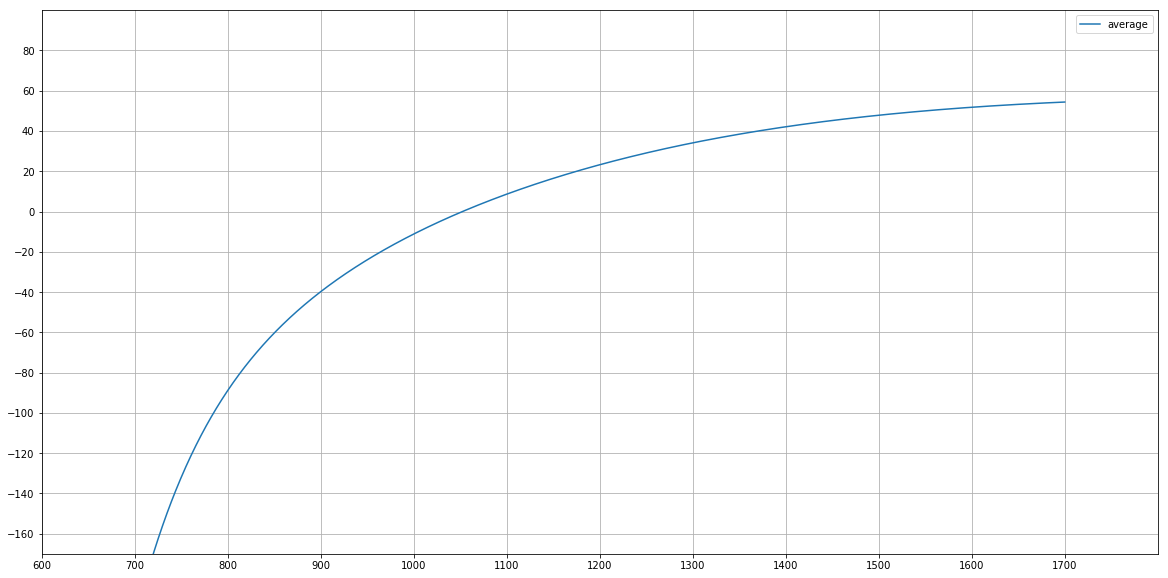

In [22]:
fig = plt.figure(figsize=(20,10))

for i in range(len(axeses)):
    plt.plot(lamda*1e9, D_large[i], label = axeses[i])
plt.yticks(np.arange(-160,90,20))
plt.xticks(np.arange(600,1800,100))
plt.grid()
plt.legend()
plt.ylim(-170,100)
plt.xlim(600, 1800)
plt.savefig('dispersion.png', bbox_inches = 'tight')
plt.show()

## Conclusion. Dispersion seems just fine, the only difference that we get is far away from the ZDW and that is found to be because I do not have all the betas ( yes beta6 plays a role at a large avelength distance). but all in all for the wavelengths we are looking for we are fine. 

# WDM lookover
Now WDM's are a problem. I cannot find a book on how to model the couplers but I can easily find afew lecture notes shown in: [here](graphs_for_logs/single_mode_single_dirrection/movies/PC481 course notes9.pdf)
and [here](graphs_for_logs/lesson 06_new.pdf). 

They talk about the WDM couplers as a 2D system as I said earlier but with a difference:
$$\begin{bmatrix}
    U^{1}_{out}         \\
    U^{2}_{out}      
\end{bmatrix} =
\begin{bmatrix}
    \sqrt{\epsilon} & j \sqrt{ 1 - \epsilon} \\
    j \sqrt{ 1 - \epsilon}       &  \sqrt{\epsilon}
\end{bmatrix}\begin{bmatrix}
    U^{1}_{in} \\
    U^{2}_{in}      
\end{bmatrix}
$$


They prety much state what I have implemented expect that they have included the concept of the imaginary part. This leads the WDM's and splices to be formulated differently i.e.:



The matrix that can represent the system WDM system with $$\epsilon = sin^{2}\left(f(\lambda)\right)$$ is shown:

$$\begin{bmatrix}
    U^{1}_{out}         \\
    U^{2}_{out}      
\end{bmatrix} =
\begin{bmatrix}
    sin(f(\lambda))       & j cos(f(\lambda)) \\
    j cos(f(\lambda))       &  sin(f(\lambda)) 
\end{bmatrix}\begin{bmatrix}
    U^{1}_{in} \\
    U^{2}_{in}      
\end{bmatrix}
$$

and with  $$\epsilon = 10^{0.1 L}$$

$$\begin{bmatrix}
    E^{1}_{out}         \\
    E^{2}_{out}      
\end{bmatrix} =
\begin{bmatrix}
    10^{0.1 L/2}       & j \sqrt{ 1 - 10^{0.1 L}} \\
     j \sqrt{ 1 - 10^{0.1 L}}       &  10^{0.1 L/2} 
\end{bmatrix}\begin{bmatrix}
    E^{1}_{out} \\
    E^{2}_{out}      
\end{bmatrix}
$$


Both pass the tests of conservation of energy.


# Meeting
Had meeting with Peter, notebook is in the supervisory team folder along with the output.

# Entry on WDM's 

If we are to assume that the WDM's are a 2x2 coupler then we need to know if the WDM is with respect to frequency or wavelength. 

A 2x2 coupler becomes a WDM is made in to a WDM by slicing it at certain length. The depedence in the freequency comes from the coupling constant in coupling theory[ reference Okamoto]:

the couplign constant in a 2x2 coupler is found by:

$$
\kappa = \frac{k^{2}}{2 \beta} \frac{\int \left(n^2 - n^{2}_{2} \right) E_{1}^{*}E_{2} dx dy}{ \int \left| E_{1} \right|^{2} dx dy}  \propto \frac{k^{2}}{2 \beta} = \frac{ \pi f}{n_{eff} c} \propto f
$$


Hence since the coupling constant is proportional to freequency this means that $\epsilon $ from above will be a $sin$ with respect to freequency and needs to be manilulated in the equation.

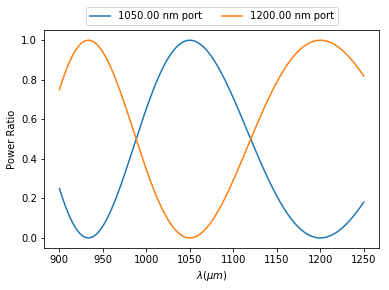

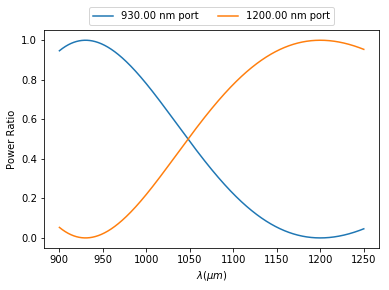

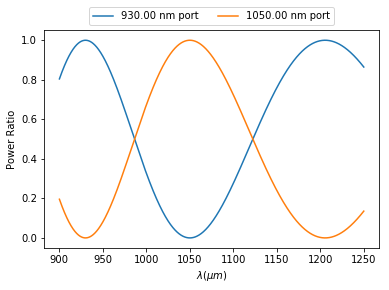

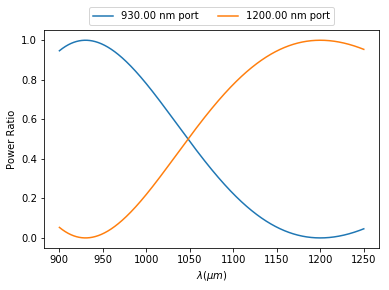

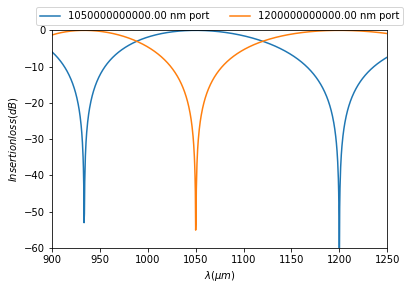

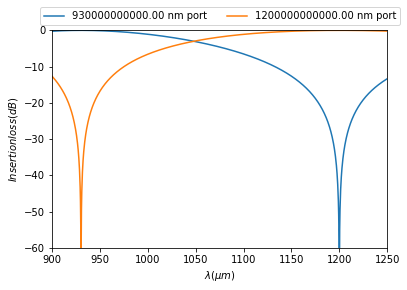

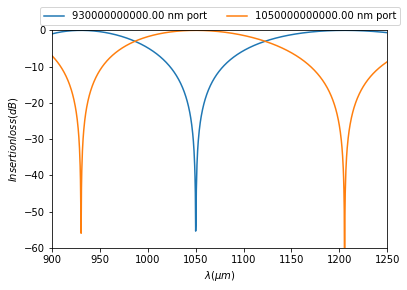

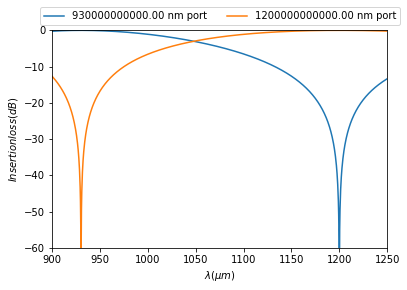

In [3]:
%matplotlib inline
from functions import *
lv = np.linspace(900, 1250, 1024)
fv = 1e3 * c/ lv
WDM1 = WDM(1050, 1200,lv, c)
WDM2 = WDM(930, 1200, lv, c)
WDM3 = WDM(930, 1050, lv, c)
WDM4 = WDM(930, 1200, lv, c)
WDM1.plot(lamda = lv)
WDM2.plot(lamda = lv)
WDM3.plot(lamda = lv)
WDM4.plot(lamda = lv)
WDM1.plot_dB(lamda = lv)
WDM2.plot_dB(lamda = lv)
WDM3.plot_dB(lamda = lv)
WDM4.plot_dB(lamda = lv)

# incooporating a supergaussian in to the loss function

I am afraid of freequencies shifting to the other side of the spectrum. Up until now I have been using a trapezoid however this can give me problems because the fourier transforms do not deal well with sharp drops. One good alternative is the supergaussian. 



In [313]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
def super_gauss(T, m,so):
    #(1/((2*np.pi)**0.5)*so)*
    return np.exp(-0.5*(np.abs(T)**2/(2*so**2))**m)

In [350]:
T = np.linspace(-100,100,1024)

In [359]:
so = 30
m =9
y = super_gauss(T,m,so)

In [360]:
s = so * (np.pi/2)**(2/m - 1)


63.34390415829358


<IPython.core.display.Javascript object>


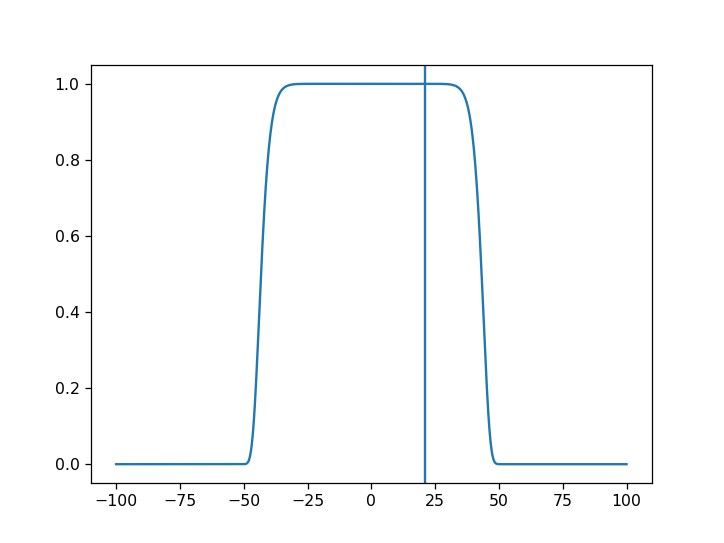

In [361]:
%matplotlib notebook
plt.plot(T,y)
plt.axvline(s)
plt.show()